In [1]:
# Data processing
import pandas as pd
import numpy as np
import datetime as dt

# Distance Calculation
from math import sin, cos, sqrt, atan2, radians

# Geographic data
# from mpl_toolkits.basemap import Basemap
import shapefile
from shapely.geometry import shape, mapping, Point, Polygon, MultiPolygon
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic as geodesic

# Visualization
import seaborn as sb
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Control Variables

In [2]:
PATH = "./all/basic_filter-"
# PATH = "./all/basic_filter_drop_datetime"

# read whole file use None
# ROWS = None 
ROWS = 500_000

HEADERS = ['fare_amount', 'passenger_count', 'new_york_time', 'year', 'weekday', 'hour', 'dist']

LEFT_BOTTOM_CITY = 'Tennessee'
RIGHT_TOP_CITY = 'Maine'

NYC_LONGITUDE = (-74.256436, -73.699733)
NYC_LATITUDE = (40.495029, 40.915592)

JFK_LONGITUDE = (-73.789185, -73.775291)
JFK_LATITUDE = (40.641960, 40.649562)

# Taxicab Rate of Fare
MILEAGE = 0.4 * 5

* location shape

In [3]:
nyc_pts = [Point(-73.908981, 40.913639), \
           Point(-73.783747, 40.878814), \
           Point(-73.773364, 40.797500), \
           Point(-73.702160, 40.751333), \
           Point(-73.737836, 40.595225), \
           Point(-73.948097, 40.539782), \
           Point(-74.052133, 40.585874), \
           Point(-74.246933, 40.486105), \
           Point(-74.259249, 40.516316), \
           Point(-74.187834, 40.646473), \
           Point(-74.078001, 40.651541)]
manual_nyc = Polygon([[p.x, p.y] for p in nyc_pts])

mht_pts = [Point(-73.924685, 40.878953), \
           Point(-74.008196, 40.754634), \
           Point(-74.017773, 40.704438), \
           Point(-73.978666, 40.711991), \
           Point(-73.938492, 40.783763), \
           Point(-73.926129, 40.780638), \
           Point(-73.913754, 40.793896), \
           Point(-73.931268, 40.802745), \
           Point(-73.935373, 40.834736), \
           Point(-73.909554, 40.873484)]
manual_manhattan = Polygon([[p.x, p.y] for p in mht_pts])

jfk_pts = [Point(-73.796421, 40.649549), \
           Point(-73.794189, 40.641083), \
           Point(-73.780287, 40.634830), \
           Point(-73.771487, 40.645737), \
           Point(-73.784447, 40.651828), \
           Point(-73.791872, 40.651210)]
manual_jfk = Polygon([[p.x, p.y] for p in jfk_pts])

nwk_pts = [Point(-74.179868, 40.700166), \
           Point(-74.169654, 40.694894), \
           Point(-74.179785, 40.684124), \
           Point(-74.187337, 40.687085)]
manual_newark = Polygon([[p.x, p.y] for p in nwk_pts])

# city_polys = [manhattan, bronx, staten_island, brooklyn, queens]
manual_city_polys = [manual_manhattan, manual_jfk, manual_newark]

In [4]:
geolocator = Nominatim(user_agent='city')
LEFT_BOTTOM_BOUNDARY = geolocator.geocode(LEFT_BOTTOM_CITY)
RIGHT_TOP_BOUNDARY = geolocator.geocode(RIGHT_TOP_CITY)

## Auxiliary Functions

---

### Func for filtering

In [5]:
def basic_pearson_corr_result(df, title):
    print('{title}, Pearson correlation coef. of:'.format(title=title))
    format_rule = '    {0:30}'
    # Euclidean distance of the ride and the taxi fare
    print(format_rule.format('dist and fare: '), \
          df['dist'].corr(df['fare_amount']))
    # time of day and distance traveled
    print(format_rule.format('time of day and dist: '), \
          df['hour'].corr(df['dist']))
    # time of day and the taxi fare
    print(format_rule.format('time of day and fare: '), \
          df['hour'].corr(df['fare_amount']))
    
def basic_visualization_result(df):
    df.plot(kind='scatter', x='dist', y='fare_amount')
    df.plot(kind='scatter', x='dist', y='hour')
    df.plot(kind='scatter', x='hour', y='fare_amount')
    
def compare_two_df(df1, title1, df2, title2):
    title_rule = '    {}'
    data_rule = '        {0:30}'

    # Euclidean distance of the ride and the taxi fare
    print('Pearson correlation coef. of:')
    print(title_rule.format('* dist and fare: '))
    print(data_rule.format(title1), \
          df1['dist'].corr(df1['fare_amount']))
    print(data_rule.format(title2), \
          df2['dist'].corr(df2['fare_amount']))

    print(title_rule.format('* time of day and dist: '))
    print(data_rule.format(title1), \
          df1['hour'].corr(df1['dist']))
    print(data_rule.format(title2), \
          df2['hour'].corr(df2['dist']))

    print(title_rule.format('* time of day and fare: '))
    print(data_rule.format(title1), \
          df1['hour'].corr(df1['fare_amount']))
    print(data_rule.format(title2), \
          df2['hour'].corr(df2['fare_amount']))

#     fig = plt.figure(figsize=(32,32))
#     ax1_1 = fig.add_subplot(321)
#     ax2_1 = fig.add_subplot(322)
#     ax1_2 = fig.add_subplot(323)
#     ax2_2 = fig.add_subplot(324)
#     ax1_3 = fig.add_subplot(325)
#     ax2_3 = fig.add_subplot(326)

#     df1.plot(ax=ax1_1, kind='scatter', x='dist', y='fare_amount', title = title1)
#     df1.plot(ax=ax1_2, kind='scatter', x='dist', y='hour', title = title1)
#     df1.plot(ax=ax1_3, kind='scatter', x='hour', y='fare_amount', title = title1)
#     df2.plot(ax=ax2_1, kind='scatter', x='dist', y='fare_amount', title = title2)
#     df2.plot(ax=ax2_2, kind='scatter', x='dist', y='hour', title = title2)
#     df2.plot(ax=ax2_3, kind='scatter', x='hour', y='fare_amount', title = title2)

### Basic Filter

In [6]:
def valid_fare(row_data):
    """
    this is a soft cut based on initial chare $2.50 and the improvement surcharge 30-cent
    """
    return row_data['fare_amount'] > 2.8

def valid_transportation_region(row_data, left_bottom = LEFT_BOTTOM_BOUNDARY, right_top = RIGHT_TOP_BOUNDARY):
    """
    default region based on the rectangle formed by Tennessee and Maine, 
    since it takes more than 12 hrs to drive from the boundary to NYC or
    from NYC to the boundary
    """
    return (row_data['pickup_longitude'] > left_bottom.longitude) & \
           (row_data['pickup_longitude'] < right_top.longitude) & \
           (row_data['dropoff_longitude'] > left_bottom.longitude) & \
           (row_data['dropoff_longitude'] < right_top.longitude) & \
            (row_data['pickup_latitude'] > left_bottom.latitude) & \
            (row_data['pickup_latitude'] < right_top.latitude) & \
            (row_data['dropoff_latitude'] > left_bottom.latitude) & \
            (row_data['dropoff_latitude'] < right_top.latitude)

def dest_in_nyc_helper(row_data, city_poly = manual_nyc):    
    return shape(Point(row_data['dropoff_longitude'], row_data['dropoff_latitude'])).within(city_poly)


def orig_in_nyc_helper(row_data, city_poly = manual_nyc):
    return shape(Point(row_data['pickup_longitude'], row_data['pickup_latitude'])).within(city_poly)

def valid_transportation_region_by_shape(row_data, city_poly = manual_nyc):
    return orig_in_nyc_helper(row_data, city_poly = city_poly) | \
           dest_in_nyc_helper(row_data, city_poly = city_poly)

def valid_travel_location(row_data):
    """
    pickup and dropoff should not be exactly the same or
    both outside the NYC 
    """
    return (row_data['pickup_longitude'] != row_data['dropoff_longitude']) | \
           (row_data['pickup_latitude'] != row_data['dropoff_latitude']) | \
           (\
            (row_data['pickup_longitude'] >= NYC_LONGITUDE[0]) & \
            (row_data['pickup_longitude'] <= NYC_LONGITUDE[1]) & \
            (row_data['pickup_latitude'] >= NYC_LATITUDE[0]) & \
            (row_data['pickup_latitude'] <= NYC_LATITUDE[1]) \
           ) | (\
            (row_data['dropoff_longitude'] >= NYC_LONGITUDE[0]) & \
            (row_data['dropoff_longitude'] <= NYC_LONGITUDE[1]) & \
            (row_data['dropoff_latitude'] >= NYC_LATITUDE[0]) & \
            (row_data['dropoff_latitude'] <= NYC_LATITUDE[1]) \
           )

def valid_passenger_count(row_data):
    """
    by Taxi rule, the maximum capacity is 6
    """
    return (row_data['passenger_count'] > 0) & (row_data['passenger_count'] <= 6)

### Advanced Filter

In [7]:
def valid_fare_amount_judge_by_travel_distance(row_data):
    return valid_fare_amount_with_long_distance(row_data) & \
           valid_fare_amount_with_short_distance(row_data)

def valid_fare_amount_with_long_distance(row_data):
    return row_data['fare_amount'] >= (row_data['dist'] * MILEAGE + 2.8)

def valid_fare_amount_with_short_distance(row_data):
    return (row_data['dist'] >= 0.2) | (row_data['fare_amount'] <= 10)

def valid_fare_with_upperbound(row_data, amount = 500):
    return row_data['fare_amount'] < amount

def filter_by_locations(df, orig_dest1, orig_dest2 = None):
    if orig_dest2:
        return df.loc[((df['orig_loc'] == orig_dest1[0]) & \
                       (df['dest_loc'] == orig_dest1[1])) | \
                      ((df['orig_loc'] == orig_dest2[0]) & \
                       (df['dest_loc'] == orig_dest2[1]))]
    else:
        return df.loc[(df['orig_loc'] == orig_dest1[0]) & \
                      (df['dest_loc'] == orig_dest1[1])]

def filter_traffic_rush_hour(row_data):
    return (row_data['weekday'] < 5) & \
           (((row_data['hour'] >= 7) & \
            (row_data['hour'] <= 10)) | \
           ((row_data['hour'] >= 15) & \
            (row_data['hour'] <= 19)))
# # flat
# manhattan_jfk = filter_by_locations(train_df, (0, 1), (1, 0))

# # metered + flat
# anywhere_newark = filter_by_locations(train_df, ())
# anywhere_newark = basic_filter_df.loc[(basic_filter_df['orig_loc'] != 2) & \
#                                       (basic_filter_df['dest_loc'] == 2)]
# # except to airport
# anywhere = basic_filter_df.loc[((basic_filter_df['orig_loc'] != 1) & \
#                                 (basic_filter_df['orig_loc'] != 2)) | \
#                                ((basic_filter_df['orig_loc'] != 2) & \
#                                 (basic_filter_df['orig_loc'] != 1))]

# # travel in manhattan
# manhattan_manhattan = filter_by_locations(train_df, (0, 0))

# # weird cases
# jfk_jfl = filter_by_locations(train_df, (1, 1))
# newark_newark = filter_by_locations(train_df, (2, 2))

# format_rule = '{:65}'
# print(format_rule.format('Orignal data size:'), basic_filter_df.shape[0])
# print(format_rule.format('From anywhere except airports to anywhere except airports:'), anywhere.shape[0])
# print(format_rule.format('From manhattan to manhattan:'), manhattan_manhattan.shape[0])
# print(format_rule.format('From manhattan to jfk or from jfk to manhattan:'), manhattan_jfk.shape[0])
# print(format_rule.format('From anywhere to newark:'), anywhere_newark.shape[0])
# print(format_rule.format('From jfk to jfk (weird case):'), jfk_jfk.shape[0])
# print(format_rule.format('From newark to newark (weird case):'), newark_newark.shape[0])

### Func for insertion

In [8]:
def dist(row_data):
    R = 6373.0
    s_lon = radians(row_data['pickup_longitude'])
    s_lat = radians(row_data['pickup_latitude'])
    e_lon = radians(row_data['dropoff_longitude'])
    e_lat = radians(row_data['dropoff_latitude'])
    diff_lon = e_lon - s_lon
    diff_lat = e_lat - s_lat

    a = sin(diff_lat / 2)**2 + cos(s_lat) * cos(e_lat) * sin(diff_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c * 0.621371

def dist_by_geopy(row_data):
    s_lon = row_data['pickup_longitude']
    s_lat = row_data['pickup_latitude']
    e_lon = row_data['dropoff_longitude']
    e_lat = row_data['dropoff_latitude']
    return geodesic((s_lon, s_lat), (e_lon, e_lat)).miles

# clean_data['dist'] = np.vectorize(dist)(clean_data['pickup_longitude'], clean_data['pickup_latitude'], clean_data['dropoff_longitude'], clean_data['dropoff_latitude'])
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude/19412565


# def to_jfk(row_data):
#     if ((row_data['dropoff_longitude'] >= JFK_LONGITUDE[0]) & \
#        (row_data['dropoff_longitude'] <= JFK_LONGITUDE[1]) & \
#        (row_data['dropoff_latitude'] >= JFK_LATITUDE[0]) & \
#        (row_data['dropoff_latitude'] <= JFK_LATITUDE[1])):
#         return 1
#     else:
#         return 0
    
# def from_jfk(row_data):
#     if ((row_data['pickup_longitude'] >= JFK_LONGITUDE[0]) & \
#         (row_data['pickup_longitude'] <= JFK_LONGITUDE[1]) & \
#         (row_data['pickup_latitude'] >= JFK_LATITUDE[0]) & \
#         (row_data['pickup_latitude'] <= JFK_LATITUDE[1])):
#         return 1
#     else:
#         return 0

def airport_jfk_rule(row_data):
    if ((row_data['orig_loc'] == 0) & \
        (row_data['dest_loc'] == 1)) | \
       ((row_data['orig_loc'] == 1) & \
        (row_data['dest_loc'] == 0)):
        return 1
    else:
        return 0
    
def airport_newark_rule(row_data):
    if (row_data['orig_loc'] != 2) & \
       (row_data['dest_loc'] == 2):
        return 1
    else:
        return 0

def metered_rule(row_data):
    if (row_data['jfk'] == 0) & \
       (row_data['newark'] == 0):
        return 1
    else:
        return 0
    
def is_weekend(row_data):
    if row_data['weekday'] > 4:
        return 1
    else:
        return 0

def is_night_time(row_data):
    if (row_data['hour'] >= 20) | \
       (row_data['hour'] <= 6):
        return 1
    else:
        return 0

def weekday_rush_hour(row_data):
    if (is_weekend(row_data) == 0) & \
       (row_data['hour'] >= 16) & \
       (row_data['hour'] <= 20):
        return 1
    else:
        return 0    
    
def remove_outliers_Tukey(usefulData, attr):
    thirdQuartile = usefulData.quantile(.75)[attr]
    firstQuartile = usefulData.quantile(.25)[attr]
    IQR = thirdQuartile - firstQuartile
    return usefulData[usefulData[attr].between(firstQuartile - (IQR * 1.5), thirdQuartile + (IQR * 1.5))]

### Func for visualization

In [9]:
def plot_hist(df, headers, log = False):
    ax = []
    fig = plt.figure(figsize=(8,8))
    for idx, header in enumerate(headers):
        loc = 331 + idx
        ax = fig.add_subplot(loc)
        df[header].hist(ax = ax, bottom = 0)
        if log:
            header += ' (log)'
            ax.set_yscale('log')
        ax.set_title(header)
    fig.tight_layout()
    plt.show()

## Adjust or Create Feature

In [10]:
def insert_est_or_edt_time(df):
    df.insert(df.shape[1],'new_york_time',
              df.pickup_datetime.dt.tz_localize('utc').\
              dt.tz_convert('America/New_York'))
    
def insert_year(df):
    df.insert(df.shape[1], 'year', df.new_york_time.dt.year)

def insert_weekday(df):
    df.insert(df.shape[1], 'weekday', df.new_york_time.dt.weekday)

def insert_time_of_day(df):
    df.insert(df.shape[1], 'hour', df.new_york_time.dt.hour + df.new_york_time.dt.minute/60)

# def insert_dist(df, func = dist):
#     euclidean_dist = df.apply(func, axis = 1)
#     df.insert(df.shape[1], 'dist', euclidean_dist)
    
def insert_feature(df, func = None, feature_name = None):
    new_data = df.apply(func, axis = 1)
    df.insert(df.shape[1], feature_name, new_data)

# Deal with Extra Dataset
* Borough Boundaries - https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
* Airport Polygons - https://data.cityofnewyork.us/City-Government/Airport-Polygon/xfhz-rhsk
* Newark GIS: http://data.ci.newark.nj.us/dataset/newark-airport
* New York City Hourly Traffic Estimates (2010-2013) - https://databank.illinois.edu/datasets/IDB-4900670

In [11]:
city_poly = shapefile.Reader("./datasets/BoroughBoundaries/geo_export_da72d38f-f1ec-4fa6-977d-5cf707cef1dd.shp")
airport_poly = shapefile.Reader("./datasets/AirportPolygon/geo_export_76666281-a938-4489-b8b4-9871d60cffcd.shp")
newark_airport = shapefile.Reader("./datasets/AirportPolygon/NewarkAirport.shp")

In [12]:
def print_poly_name(shapefile):
    for shareRecord in shapefile.iterShapeRecords():
        print(shareRecord.record)

print_poly_name(city_poly)
print_poly_name(airport_poly)

# a = Point(base_df['pickup_longitude'].iloc[0], base_df['pickup_latitude'].iloc[0])
# b = shape(a)

['Manhattan', 361649.881587, 1.0, 636600558.138]
['Bronx', 463464.521828, 2.0, 1186615448.62]
['Staten Island', 330432.867999, 5.0, 1623920681.95]
['Brooklyn', 739945.437431, 3.0, 1937566944.36]
['Queens', 895228.96036, 4.0, 3044771591.17]
[0.0, 'La Guardia Airport', 0.0, 'http://www.panynj.gov/CommutingTravel/airports/html/laguardia.html', 17879876.6217]
[0.0, 'John F. Kennedy International Airport', 0.0, 'http://www.panynj.gov/CommutingTravel/airports/html/kennedy.html', 97393969.0286]


In [13]:
manhattan = shape(city_poly.shapeRecords()[0].shape.__geo_interface__)
bronx = shape(city_poly.shapeRecords()[1].shape.__geo_interface__)
staten_island = shape(city_poly.shapeRecords()[2].shape.__geo_interface__)
brooklyn = shape(city_poly.shapeRecords()[3].shape.__geo_interface__)
queens = shape(city_poly.shapeRecords()[4].shape.__geo_interface__)
laguadia = shape(airport_poly.shapeRecords()[0].shape.__geo_interface__)
jfk = shape(airport_poly.shapeRecords()[1].shape.__geo_interface__)

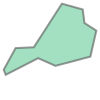

In [14]:
manual_nyc

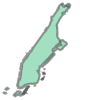

In [15]:
manhattan

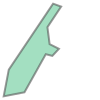

In [16]:
manual_manhattan

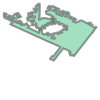

In [17]:
jfk

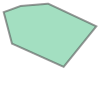

In [18]:
manual_jfk

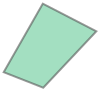

In [19]:
manual_newark

In [20]:
def to_location(row_data, locations = manual_city_polys):
    point = shape(Point(row_data['dropoff_longitude'], row_data['dropoff_latitude']))

    for idx, location in enumerate(locations):
        if point.within(location):
            return idx
    return -1

def from_location(row_data, locations = manual_city_polys):
    point = shape(Point(row_data['pickup_longitude'], row_data['pickup_latitude']))

    for idx, location in enumerate(locations):
        if point.within(location):
            return idx
    return -1


# Linear Regression

In [21]:
def simple_linear_regression(df, x_feature, y_feature, test_size = 0.3):
    train, test = train_test_split(df, test_size = test_size)
    train_x = list(map(lambda x: [x], list(train[x_feature])))
    train_y = list(map(lambda x: [x], list(train[y_feature])))
    test_x = list(map(lambda x: [x], list(test[x_feature])))
    test_y = list(map(lambda x: [x], list(test[y_feature])))

    regr = linear_model.LinearRegression()
    regr.fit(train_x, train_y)
    fare_predict = regr.predict(test_x)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(test_y, fare_predict))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(test_y, fare_predict))

    # Plot outputs
    plt.scatter(test_x, test_y,  color='blue')
    plt.plot(test_x, fare_predict, color='red', linewidth=3)

    plt.xticks(())
    plt.yticks(())

    plt.show()
    
    return regr

In [22]:
def normalize_fare(row_data, inverse = False):
    adjust_fare = 0
    
    sign = 1

    if inverse:
        sign = -1
        adjust_fare = row_data['adjusted_fare_amount']
    else:
        adjust_fare = row_data['fare_amount']
        
    if row_data['jfk'] == 1:
        # flat fare of $52
        if row_data['year'] < 2013:
            adjust_fare -= (sign * 45)
        else:
            adjust_fare -= (sign * 52)

        # MTA State Surcharge
        adjust_fare -= (sign * 0.5)
        # 30-cent Improvement Surcharge,
        adjust_fare -= (sign * 0.3)
        # toll
        adjust_fare -= (sign * 5)
        
        if row_data['weekday_rush_hour'] == 1:
            adjust_fare -= (sign * 4.5)
    else:    
        # metered surcharge
        adjust_fare -= (sign * 2.8)
        
        if row_data['night_time'] == 1:
            adjust_fare -= (sign * 0.5)
        
        if row_data['weekday_rush_hour'] == 1:
            adjust_fare -= (sign * 1)
        
        # newark rule
        if row_data['newark'] == 1:
            # flat
            if row_data['year'] < 2013:
                adjust_fare -= (sign * 15)
            else:
                adjust_fare -= (sign * 17.5)
            
            # surcharge
            adjust_fare -= (sign * 0.3)
            # round trip toll
            adjust_fare -= (sign * 12.5)

    return adjust_fare


def inverse_normalize_fare(row_data):
    return normalize_fare(row_data, inverse = True)

# def inverse_adjusted_fare(row_data):
#     fare = row_data['adjusted_fare_amount']

#     if row_data['jfk'] == 1:
#         fare = 0
#         # flat fare of $52
#         if row_data['year'] < 2014:
#             fare += 45
#         else:
#             fare += 52

#         # MTA State Surcharge
#         fare += 0.5
#         # 30-cent Improvement Surcharge,
#         fare += 0.3        
#         # toll
#         fare += 5
        
#         if row_data['weekday_rush_hour'] == 1:
#             fare += 4.5
#     else:
#         fare += 2.8
        
#         if row_data['night_time'] == 1:
#             fare += 0.5
        
#         if row_data['weekday_rush_hour'] == 1:
#             fare += 1
        
#         if row_data['newark'] == 1:
#             # flat
#             fare += 17.5
#             # surcharge
#             fare += 0.3
#             # round trip toll
#             fare += 12.5

#     return fare

# Q1 Take a look at the training data ...

## There may be anomalies in the data that you may need to factor in before you start on the other tasks. Clean the data first to handle these issues. Explain what you did to clean the data (in bulleted form).

## Basic Visualization
---

In [23]:
# Read feather

basic_filter_df = pd.read_feather(PATH+str(ROWS))
# basic_filter_df = pd.read_feather(PATH)



/anaconda3/envs/data-science/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [24]:
advanced_df = basic_filter_df.loc[valid_fare_amount_judge_by_travel_distance(basic_filter_df)]
w_upperbound_df = advanced_df.loc[valid_fare_with_upperbound(advanced_df, 300)]
w_shape_df = w_upperbound_df.loc[w_upperbound_df.apply(valid_transportation_region_by_shape, axis = 1)]

compare_two_df(basic_filter_df, 'Applied basic rules', advanced_df, 'Applied travel distance rules')
print('\n')
compare_two_df(advanced_df, 'Applied travel distance rules', w_upperbound_df, 'Applied upperbound fare rule')
print('\n')
compare_two_df(w_upperbound_df, 'Applied upper bound rule', w_shape_df, 'Applied advanced shape rule')

Pearson correlation coef. of:
    * dist and fare: 
        Applied basic rules            0.67449629783
        Applied travel distance rules  0.908483019109
    * time of day and dist: 
        Applied basic rules            0.0212993969933
        Applied travel distance rules  0.0308010718408
    * time of day and fare: 
        Applied basic rules            -0.0036685924712
        Applied travel distance rules  -0.00629747768977


Pearson correlation coef. of:
    * dist and fare: 
        Applied travel distance rules  0.908483019109
        Applied upperbound fare rule   0.908483019109
    * time of day and dist: 
        Applied travel distance rules  0.0308010718408
        Applied upperbound fare rule   0.0308010718408
    * time of day and fare: 
        Applied travel distance rules  -0.00629747768977
        Applied upperbound fare rule   -0.00629747768977


Pearson correlation coef. of:
    * dist and fare: 
        Applied upper bound rule       0.908483019109
        

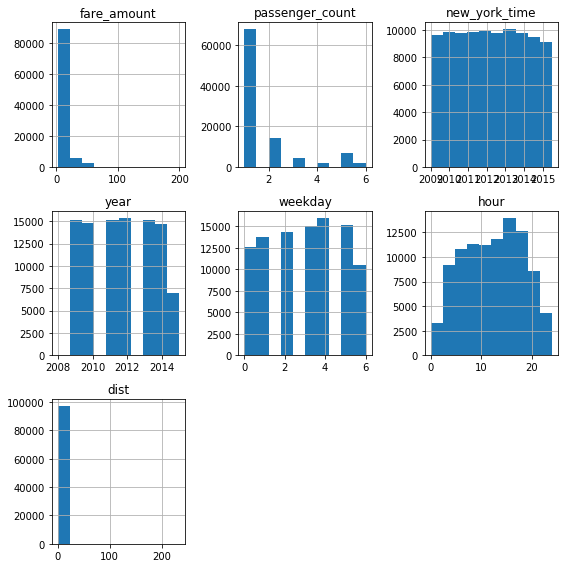


 log hist


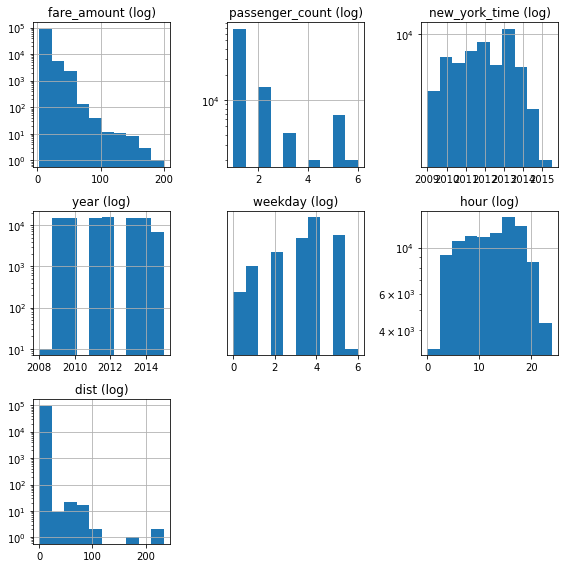

In [25]:
# headers = list(basic_filter_df.columns.values)
plot_hist(basic_filter_df, HEADERS)
print('\n log hist')
plot_hist(basic_filter_df, HEADERS, log = True)

In [26]:
basic_filter_df.loc[basic_filter_df.fare_amount > 300].describe()

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,dist
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning and Visualization
---

## Pearson Correlation Coefficients, 
## and Visualization of the Relation between the Variables

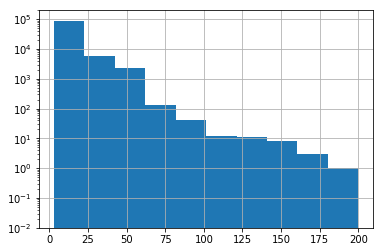

In [27]:
fig, ax = plt.subplots()
basic_filter_df.fare_amount.hist(ax = ax, bottom=0.01)
ax.set_yscale('log')

Size of data (with basic filtering rules):             97155
Size of data (with advanced filtering rules):          92888
Size of data (with fare-upperbound filtering rules):   92888
Size of data (with tighter shape filtering rules):     92786


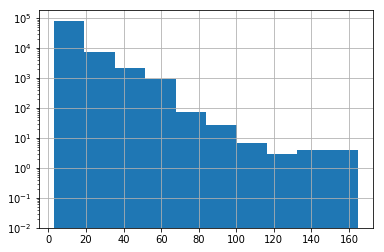

In [28]:
fig, ax = plt.subplots()
w_shape_df.fare_amount.hist(ax = ax, bottom=0.01)
ax.set_yscale('log')
format_rule = '{0:54}'
print(format_rule.format('Size of data (with basic filtering rules):'), basic_filter_df.shape[0])
print(format_rule.format('Size of data (with advanced filtering rules):'), advanced_df.shape[0])
print(format_rule.format('Size of data (with fare-upperbound filtering rules):'),w_upperbound_df.shape[0])
print(format_rule.format('Size of data (with tighter shape filtering rules):'),w_shape_df.shape[0])

train_df = w_shape_df[:]

In [29]:
train_df.head()

,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_york_time,year,weekday,hour,dist
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009,0,13.433333,0.640688
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010,1,11.866667,5.252316
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011,2,20.583333,0.863682
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012,5,0.500000,1.739931
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010,1,2.850000,1.242608


# Histogram

---

## Weekday

---

## Weekend

In [30]:
# weekends_df = basic_filter_df.loc[]
# weekends_df.hist()
# simple_linear_regression(advanced_w_upperbound)

# Create New Features
---

In [31]:
insert_feature(train_df, feature_name='orig_loc', func=from_location)
insert_feature(train_df, feature_name='dest_loc', func=to_location)

insert_feature(train_df, feature_name='jfk', func=airport_jfk_rule)
insert_feature(train_df, feature_name='newark', func=airport_newark_rule)
# insert_feature(train_df, feature_name='metered', func=metered_rule)
insert_feature(train_df, feature_name='weekend', func=is_weekend)
insert_feature(train_df, feature_name='night_time', func=is_night_time)
insert_feature(train_df, feature_name='weekday_rush_hour', func=weekday_rush_hour)
insert_feature(train_df, feature_name='adjusted_fare_amount', func=normalize_fare)
insert_feature(train_df, feature_name='inversed_adjusted_fare', func=inverse_normalize_fare)

# print(train_df.loc[train_df.jfk == 1].shape[0] + \
#       train_df.loc[train_df.newark == 1].shape[0] + \
#       train_df.loc[train_df.metered == 1].shape[0])
# print(train_df.shape[0])

train_df.describe()

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,dist,orig_loc,dest_loc,jfk,newark,weekend,night_time,weekday_rush_hour,adjusted_fare_amount,inversed_adjusted_fare
count,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.00000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000,92786.000000
mean,49958.739476,11.522644,-73.975540,40.750829,-73.974348,40.751228,1.684780,2011.785356,2.977669,12.276738,2.115990,-0.054911,-0.105576,0.01386,0.001239,0.262022,0.278932,0.157244,7.678359,11.522644
std,28877.939209,9.399189,0.034033,0.026616,0.034061,0.030810,1.302252,1.873453,1.903661,5.823179,2.240544,0.283916,0.339331,0.11691,0.035184,0.439737,0.448477,0.364032,7.928778,9.399189
min,0.000000,2.900000,-74.122359,40.557018,-74.474595,40.518067,1.000000,2008.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-15.500000,2.900000
25%,24929.250000,6.100000,-73.992320,40.736548,-73.991418,40.735536,1.000000,2010.000000,1.000000,7.433333,0.815812,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.900000,6.100000
50%,49943.500000,8.500000,-73.982147,40.753405,-73.980521,40.753833,1.000000,2012.000000,3.000000,12.650000,1.382091,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.300000,8.500000
75%,74958.750000,12.900000,-73.968577,40.767481,-73.965486,40.768250,2.000000,2013.000000,5.000000,17.000000,2.497675,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,9.300000,12.900000
max,99999.000000,165.000000,-73.683717,40.918290,-73.499451,41.147487,6.000000,2015.000000,6.000000,23.983333,28.370615,1.000000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,161.700000,165.000000


In [ ]:
# simple_linear_regression(train_df_wo_jfk, x_feature='dist', y_feature='fare_amount')

In [ ]:
# train_df_wo_jfk = train_df.loc[train_df['jfk'] == 0]

# regr = simple_linear_regression(train_df_wo_jfk, x_feature='dist', y_feature='adjusted_fare_amount')

In [ ]:
# fare_predict = regr.predict(test_X).round(decimals = 2)

# submission = pd.DataFrame({'key': test_df.key,\
#                            'adjuted_fare_amount': fare_predict.ravel()},\
#                           columns = ['key', 'fare_amount'])

In [ ]:
# fig, ax = plt.subplots()
# weekdays_df.fare_amount.hist(ax = ax, bottom=0.01)
# ax.set_yscale('log')
# weekdays_df.weekday.hist(bins=5, grid = False)

In [ ]:
# fig = plt.figure()
# plt.hist(weekdays_df.weekday, bins=5)
# plt.xticks(range(5))
# plt.yscale('log')
# plt.show()

# Reference

other datasets: 
* Borough Boundaries - https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
* Airport Polygons - https://data.cityofnewyork.us/City-Government/Airport-Polygon/xfhz-rhsk
* New York City Hourly Traffic Estimates (2010-2013) -
https://databank.illinois.edu/datasets/IDB-4900670

# JFK 

---

* Travel in JFK (weird case)

* TO JFK

* FROM JFK

* OTHER

# From Anywhere to JFK
* assume anywhere $\in$ Manhattan

---

In [ ]:
# simple_linear_regression(other_df)
# simple_linear_regression(to_jfk_df)
# simple_linear_regression(from_jfk_df)
# simple_linear_regression(travel_in_jfk_df)

# From JFK to Anywhere

* assume anywhere $\in$ Manhattan

---

# Simple Linear Regression Model

# Prediction Baseline

In [33]:
TEST_FILE = 'test.csv'
test_df = pd.read_csv('./all/test.csv')

test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime, infer_datetime_format = True)


insert_est_or_edt_time(test_df)
insert_year(test_df)
insert_weekday(test_df)
insert_time_of_day(test_df)
insert_feature(test_df, feature_name = 'dist', func = dist)

insert_feature(test_df, feature_name='orig_loc', func=from_location)
insert_feature(test_df, feature_name='dest_loc', func=to_location)

insert_feature(test_df, feature_name='jfk', func=airport_jfk_rule)
insert_feature(test_df, feature_name='newark', func=airport_newark_rule)
# insert_feature(train_df, feature_name='metered', func=metered_rule)
insert_feature(test_df, feature_name='weekend', func=is_weekend)
insert_feature(test_df, feature_name='night_time', func=is_night_time)
insert_feature(test_df, feature_name='weekday_rush_hour', func=weekday_rush_hour)
# insert_feature(test_df, feature_name='adjusted_fare_amount', func=adjust_fare)
# insert_feature(test_df, feature_name='inversed_adjusted_fare', func=inverse_adjusted_fare)

# Create Subgroup for Decision Tree

* From Manhattan to JFK or From JFK to Manhattan
* To Newark
* Others

In [34]:
train_df_jfk = train_df.loc[train_df['jfk'] == 1]
train_df_newark = train_df.loc[train_df['newark'] == 1]
train_df_others = train_df.loc[(train_df['jfk'] == 0) & (train_df['newark'] == 0)]


size of jfk: 1286
Coefficients: 
 [[ 0.20406756]]
Mean squared error: 9.17
Variance score: 0.03


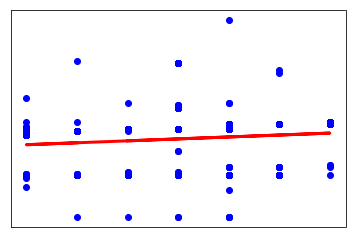

In [35]:
print('size of jfk:', train_df_jfk.shape[0])
jfk_regr = simple_linear_regression(train_df_jfk, x_feature='year', y_feature='adjusted_fare_amount')

# test_X = list(map(lambda x: [x], list(test_df.dist)))
# adjusted_fare_predict = regr.predict(test_X).round(decimals = 2)

size of newark: 115
Coefficients: 
 [[ 5.59609945]]
Mean squared error: 304.19
Variance score: -1.52


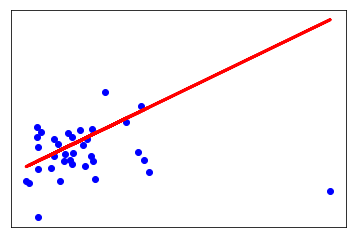

,index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,dist,orig_loc,dest_loc,jfk,newark,weekend,night_time,weekday_rush_hour,adjusted_fare_amount,inversed_adjusted_fare
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.0,115.0,115.0,115.000000,115.000000,115.000000,115.000000,115.000000
mean,49579.808696,70.717217,-73.983286,40.749943,-74.178837,40.691762,1.843478,2011.626087,3.182609,8.019275,11.109386,-0.008696,2.0,0.0,1.0,0.313043,0.365217,0.008696,39.078087,70.717217
std,30491.063184,13.315813,0.029703,0.023847,0.002410,0.002964,1.373887,1.789153,2.032985,4.524955,1.705685,0.209245,0.0,0.0,0.0,0.465761,0.483598,0.093250,12.731894,13.315813
min,1709.000000,37.700000,-74.016890,40.643833,-74.184050,40.687672,1.000000,2009.000000,0.000000,0.166667,8.598626,-1.000000,2.0,0.0,1.0,0.000000,0.000000,0.000000,7.100000,37.700000
25%,20456.500000,60.700000,-73.994909,40.738767,-74.181432,40.688793,1.000000,2010.000000,1.500000,4.466667,10.205810,0.000000,2.0,0.0,1.0,0.000000,0.000000,0.000000,29.600000,60.700000
50%,47221.000000,68.800000,-73.985228,40.753523,-74.177521,40.691075,1.000000,2012.000000,3.000000,9.300000,10.984890,0.000000,2.0,0.0,1.0,0.000000,0.000000,0.000000,38.200000,68.800000
75%,74696.000000,79.000000,-73.978472,40.763261,-74.177259,40.695069,2.000000,2013.000000,5.000000,11.033333,11.643698,0.000000,2.0,0.0,1.0,1.000000,1.000000,0.000000,46.600000,79.000000
max,99669.000000,145.830000,-73.781842,40.805994,-74.176633,40.695660,6.000000,2015.000000,6.000000,23.983333,21.036558,1.000000,2.0,0.0,1.0,1.000000,1.000000,1.000000,112.730000,145.830000


In [40]:
print('size of newark:', train_df_newark.shape[0])
newark_regr = simple_linear_regression(train_df_newark, x_feature='dist', y_feature='adjusted_fare_amount')
train_df_newark.describe()

Coefficients: 
 [[ 4.92255237]]
Mean squared error: 687.65
Variance score: -5.02


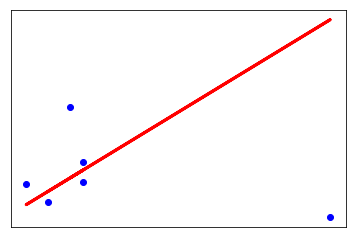

Coefficients: 
 [[-3.84207534]]
Mean squared error: 101.09
Variance score: -1.45


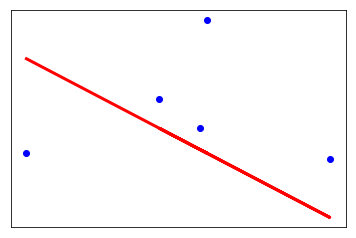

Coefficients: 
 [[-0.31313786]]
Mean squared error: 97.30
Variance score: -1.02


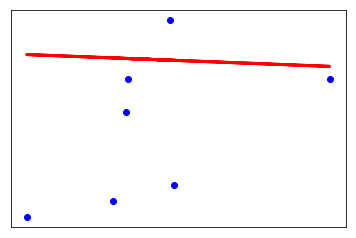

Coefficients: 
 [[ 5.54543082]]
Mean squared error: 118.92
Variance score: 0.17


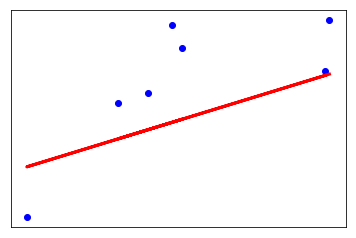

Coefficients: 
 [[ 5.60721123]]
Mean squared error: 29.01
Variance score: -0.09


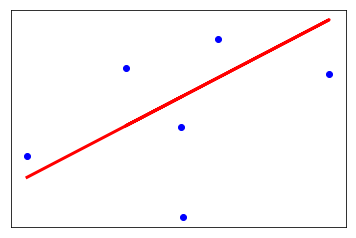

Coefficients: 
 [[ 5.18613337]]
Mean squared error: 32.56
Variance score: -1.66


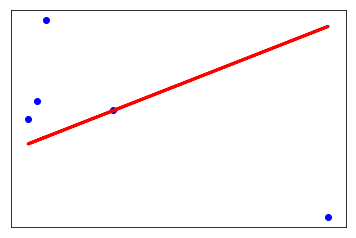

Coefficients: 
 [[-2.90009416]]
Mean squared error: 4059.68
Variance score: -2.40


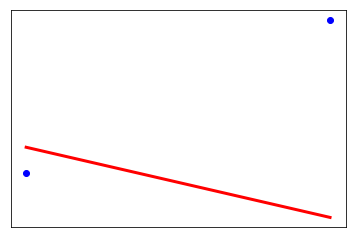

In [42]:
years = [year for year in range(2009, 2016)]
newark_regr = {}

for year in years:
    newark_regr[year] = simple_linear_regression(train_df_newark.loc[train_df_newark.year == year], x_feature='dist', y_feature='fare_amount')

Coefficients: 
 [[-0.78727597]]
Mean squared error: 124.04
Variance score: -0.54


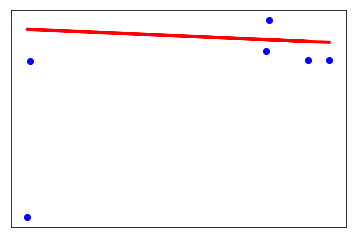

TypeError: 'LinearRegression' object does not support item assignment

In [41]:
for year in years:
    newark_regr[year] = simple_linear_regression(train_df_newark.loc[train_df_newark.year == year], x_feature='dist', y_feature='adjusted_fare_amount')


In [ ]:
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2009], x_feature='dist', y_feature='adjusted_fare_amount')
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2010], x_feature='dist', y_feature='adjusted_fare_amount')
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2011], x_feature='dist', y_feature='adjusted_fare_amount')
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2012], x_feature='dist', y_feature='adjusted_fare_amount')
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2013], x_feature='dist', y_feature='adjusted_fare_amount')
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2014], x_feature='dist', y_feature='adjusted_fare_amount')
# other_regr = simple_linear_regression(train_df_others.loc[train_df_others.year == 2015], x_feature='dist', y_feature='adjusted_fare_amount')

Coefficients: 
 [[ 3.32218908]]
Mean squared error: 7.60
Variance score: 0.81


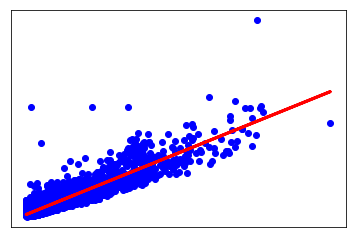

Coefficients: 
 [[ 3.27199533]]
Mean squared error: 12.09
Variance score: 0.74


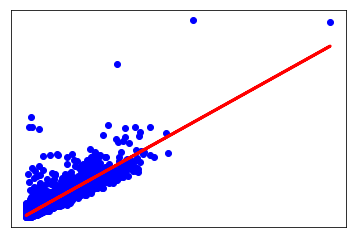

Coefficients: 
 [[ 3.39375596]]
Mean squared error: 8.11
Variance score: 0.82


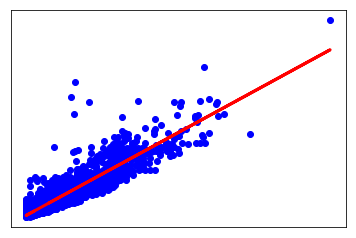

Coefficients: 
 [[ 3.6240997]]
Mean squared error: 13.60
Variance score: 0.78


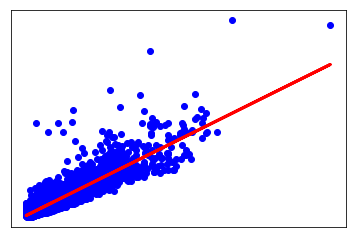

Coefficients: 
 [[ 4.15523839]]
Mean squared error: 14.95
Variance score: 0.79


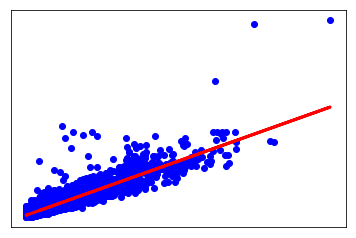

Coefficients: 
 [[ 4.25064253]]
Mean squared error: 19.98
Variance score: 0.75


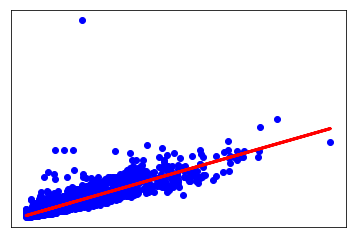

Coefficients: 
 [[ 4.372365]]
Mean squared error: 13.38
Variance score: 0.84


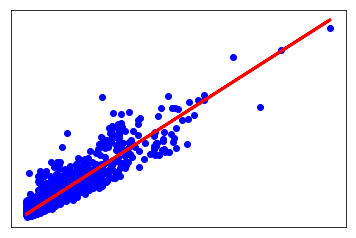

In [39]:
others_regr = {}
for year in years:
    others_regr[year] = simple_linear_regression(train_df_others.loc[train_df_others.year == year], x_feature='dist', y_feature='adjusted_fare_amount')


In [43]:
def yearly_regression(row_data, newark_regr = newark_regr, others_regr = others_regr):
#     if row_data['newark'] == 1:
#         return newark_regr[row_data['year']].predict(row_data['dist']).round(decimals = 2)[0][0]
#     else:
    return others_regr[row_data['year']].predict(row_data['dist']).round(decimals = 2)[0][0]

In [ ]:
type(fare_predict)

In [44]:
adjusted_fare_predict = test_df.apply(yearly_regression, axis = 1)

In [45]:
type(adjusted_fare_predict.values)

numpy.ndarray

In [ ]:
newark_regr

In [ ]:
test1_df = test_df[:]

In [46]:
test_df.insert(test_df.shape[1], 'adjusted_fare_amount', adjusted_fare_predict.values)

In [47]:
insert_feature(test_df, feature_name='fare_amount', func=inverse_normalize_fare)

In [48]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_york_time,year,weekday,...,dist,orig_loc,dest_loc,jfk,newark,weekend,night_time,weekday_rush_hour,adjusted_fare_amount,fare_amount
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015-01-27 08:08:24-05:00,2015,1,...,1.444059,0,0,0,0,0,0,0,6.90,9.70
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015-01-27 08:08:24-05:00,2015,1,...,1.507517,0,0,0,0,0,0,0,7.18,9.98
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011-10-08 07:53:44-04:00,2011,5,...,0.384518,0,0,0,0,1,0,0,1.59,4.39
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012-12-01 16:12:12-05:00,2012,5,...,1.218911,0,0,0,0,1,0,0,4.82,7.62
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012-12-01 16:12:12-05:00,2012,5,...,3.348564,0,0,0,0,1,0,0,12.54,15.34


In [49]:
PATH = './all/'
file = PATH + 'submission-' + str(ROWS) + '.csv'
submission = pd.DataFrame({'key': test_df.key,\
                           'fare_amount': test_df.fare_amount},\
                          columns = ['key', 'fare_amount'])
submission.to_csv(file, index = False)


In [ ]:
submission.shape

In [ ]:
file = PATH + 'submission-' + str(ROWS) + '.csv'

In [ ]:
train_df.loc[(train_df.jfk == 1)].describe()

In [ ]:
weekday_rush_df = train_df_wo_jfk.loc[filter_traffic_rush_hour(train_df_wo_jfk)]

In [ ]:
simple_linear_regression(weekday_rush_df, 'dist', 'adjusted_fare_amount')
# test_df_dist = test_df.apply(dist, axis=1)
# test_df.insert(test_df.shape[1], 'dist', test_df_dist)

In [ ]:
# test_X = list(map(lambda x: [x], list(test_df.dist)))

In [ ]:
# fare_predict = regr.predict(test_X).round(decimals = 2)

In [ ]:
test_df.head()

# Create submission file

In [ ]:
# submission = pd.DataFrame({'key': test_df.key,\
#                            'fare_amount': fare_predict.ravel()},\
#                           columns = ['key', 'fare_amount'])
# submission.to_csv('submission.csv', index = False)


In [ ]:
# submission.shape

# Extra Features 
## By year
## By weekday
## By time_of_day (hour)

## Extra Features - Adjusted_Fare_Amount_By_Rules

In [ ]:
test_df_jfk = test_df.loc[test_df.jfk == 1]
test_df_newark = test_df.loc[test_df.newark == 1]
test_df_others = test_df.loc[(test_df.jfk == 0) & (test_df.newark == 0)]
test_weird_1 = test_df.loc[(test_df.orig_loc == -1) & (test_df.dest_loc == 2)]

In [ ]:
print(test_df_jfk.shape[0])
print(test_df_newark.shape[0])
print(test_df_others.shape[0])
print(test_weird_1.shape[0])

In [ ]:
# headers = list(advanced_filter_df.columns.values)

# for header in headers:
#     print(header)

In [ ]:
# headers = zip(list(advanced_filter_df.columns.values), list(base_filter_df.columns.values))

In [ ]:
# for h1, h2 in headers:
#     print('{:30}, {:30}'.format(h1, h2))

In [ ]:
# years_df = [None for _ in range(min(clean_data.year), max(clean_data.year) + 1)]
# minimum_year = min(clean_data.year)

# years = max(clean_data.year) + 1 - minimum_year
# for year in range(years):
#     years_df[year] = clean_data[clean_data.year == minimum_year+year]
      
#     train, test = train_test_split(years_df[year], test_size=0.2)
#     train_x = list(map(lambda x: [x], list(train.dist)))
#     train_y = list(map(lambda x: [x], list(train.fare_amount)))
#     test_x = list(map(lambda x: [x], list(test.dist)))
#     test_y = list(map(lambda x: [x], list(test.fare_amount)))
#     regr.fit(train_x, train_y)
#     fare_predict = regr.predict(test_x)

#     print(years_df[year]['dist'].corr(years_df[year]['fare_amount']))
#     # The coefficients
#     print('Year: {}'.format(minimum_year + year), 'Coeff: ', regr.coef_, \
#           "M.S.E: %.2f" % (mean_squared_error(test_y, fare_predict)), \
#           'Variance score: %.2f' % r2_score(test_y, fare_predict))
#     print('\n')

    # Plot outputs
#     plt.scatter(test_x, test_y,  color='blue')
#     plt.plot(test_x, fare_predict, color='red', linewidth=3)

#     plt.xticks(())
#     plt.yticks(())

    
# plt.show()

# Night Surcharge

In [ ]:
# def night_surcharge(row_data, night = True):
#     if night:
#         return (row_data['hour'] >= 20) | (row_data['hour'] <= 6)
#     else:
#         return (row_data['hour'] < 20) & (row_data['hour'] > 6)
    
# def weekday_filter(row_data):
#     return row_data.weekday < 5 


In [ ]:
# for year in range(years):
#     night = None
#     night = years_df[year][night_surcharge(years_df[year], True)]
#     train, test = train_test_split(night, test_size=0.2)
#     train_x = list(map(lambda x: [x], list(train.dist)))
#     train_y = list(map(lambda x: [x], list(train.fare_amount)))
#     test_x = list(map(lambda x: [x], list(test.dist)))
#     test_y = list(map(lambda x: [x], list(test.fare_amount)))
#     regr.fit(train_x, train_y)
#     fare_predict = regr.predict(test_x)

#     print(night['dist'].corr(night['fare_amount']))
#     # The coefficients
#     print('Year: {}'.format(minimum_year + year), 'Coeff: ', regr.coef_, \
#           "M.S.E: %.2f" % (mean_squared_error(test_y, fare_predict)), \
#           'Variance score: %.2f' % r2_score(test_y, fare_predict))
#     print('\n')

    # Plot outputs
#     plt.scatter(test_x, test_y,  color='blue')
#     plt.plot(test_x, fare_predict, color='red', linewidth=3)

#     plt.xticks(())
#     plt.yticks(())

    
# plt.show()

In [ ]:
# for year in range(years):
#     flag = [True, False]
#     weekday = None
#     weekday = years_df[year][weekday_filter(years_df[year])]
#     train, test = train_test_split(weekday, test_size=0.2)
#     train_x = list(map(lambda x: [x], list(train.dist)))
#     train_y = list(map(lambda x: [x], list(train.fare_amount)))
#     test_x = list(map(lambda x: [x], list(test.dist)))
#     test_y = list(map(lambda x: [x], list(test.fare_amount)))
#     regr.fit(train_x, train_y)
#     fare_predict = regr.predict(test_x)

#     print(weekday['dist'].corr(weekday['fare_amount']))
#     # The coefficients
#     print('Year: {}'.format(minimum_year + year), 'Coeff: ', regr.coef_, \
#           "M.S.E: %.2f" % (mean_squared_error(test_y, fare_predict)), \
#           'Variance score: %.2f' % r2_score(test_y, fare_predict))
#     print('\n')

#     # Plot outputs
#     plt.scatter(test_x, test_y,  color='blue')
#     plt.plot(test_x, fare_predict, color='red', linewidth=3)

#     plt.xticks(())
#     plt.yticks(())

    
#     plt.show()